## **Applied Deep Learning and AI CA1 - Ciaran Dunne x00145118**





Features: 67

Seed: 30

Errors: 0.42






# Introduction

This CA covers the architecture of a neural network, choosing what hyperparameters to use to get the best results and performance from the network. Then deploying that network into production and opening a model and loading the weights, then running model on new unseen 
data instance.

# Imports

In [4]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import SGD
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import*

from keras.utils.np_utils import to_categorical
from tensorflow.keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from sklearn.utils import shuffle
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.callbacks import ModelCheckpoint

from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.models import model_from_yaml

# Creating The Dataset

In [5]:
# User values
seed = 30
np.random.seed(seed)
tf.random.set_seed(seed)


features = 67
classes = 5
n = 200000
errors = 0.42
redundant = int(features/4)


# Classification dataset
X, y = make_classification(n_samples=n, n_classes=classes, n_features=features, \
                           random_state = 1,n_informative =20, flip_y=errors, \
                           n_redundant=redundant)

# reshape y to 2D array, it needs to be to append
y = np.reshape(y, (-1, 1))

#add y to x
Xy = np.concatenate((X,y),axis=1)

np.savetxt("myCAData.csv", Xy, delimiter=",")

print(Xy[:5])


data = pd.read_csv("myCAData.csv")

[[-1.13950661e+00 -7.90354512e-01 -2.11171789e+00  6.15305579e-01
   1.21395959e-01 -1.31314648e+00  1.22711100e+00 -1.33546483e+00
   1.02512232e+01  4.45314933e-01  1.57404090e+00 -1.10615111e+00
  -3.87061352e+00 -3.87596378e+00 -2.05193658e+00  1.61710474e+00
   1.44390633e+01 -3.28089206e-01  4.54728473e-01  1.08891786e+01
   4.62014254e-01 -7.26804562e+00  1.08057736e+00  7.59529937e-02
  -5.38184897e-01 -1.55880981e+00  2.22776559e+00 -7.94660791e+00
   1.67698703e+00  5.84839068e+00 -3.74213944e+00 -9.02900254e+00
   9.89153963e-01  6.77464969e-01  2.21741386e+00  1.80294624e+00
   1.19520072e+00 -2.10762971e+00 -4.18904610e-01 -8.02830663e+00
  -3.21837910e-01 -1.17290059e+00 -9.15386815e+00 -6.19072095e-01
   4.86497757e+00  1.80883428e+00 -1.06107069e+00 -5.22561173e-01
  -9.26541022e-01 -9.22213009e-02  1.05058515e+00  5.23874814e+00
  -1.65555517e+00  2.54814066e+00 -2.94538327e+00  1.63793246e+00
   7.43968148e-01 -5.61261507e-01  3.32223993e-02 -3.69574789e-01
  -4.35055



```
# This is formatted as code
```

# Data Exploration and Visualization


In [6]:
print("Skek and description:\n--------------------------------")
print(data.skew())
print("Data Description:\n---------------------------------")
print(data.describe())

Skek and description:
--------------------------------
-1.139506610243806728e+00    0.002296
-7.903545119412396236e-01   -0.006391
-2.111717894942987783e+00   -0.038790
6.153055786762404722e-01     0.011657
1.213959587847337207e-01     0.003863
                               ...   
6.442346708295009883e+00    -0.057925
-1.841300965270312950e+00   -0.003817
1.063883455161970026e+01    -0.107562
-6.996315695634582887e-01    0.039077
1.000000000000000000e+00    -0.004996
Length: 68, dtype: float64
Data Description:
---------------------------------
       -1.139506610243806728e+00  -7.903545119412396236e-01  \
count              199999.000000              199999.000000   
mean                   -0.002518                   0.001433   
std                     1.000529                   1.002450   
min                    -4.972862                  -4.315498   
25%                    -0.676730                  -0.673758   
50%                    -0.002557                   0.000133   
75%    

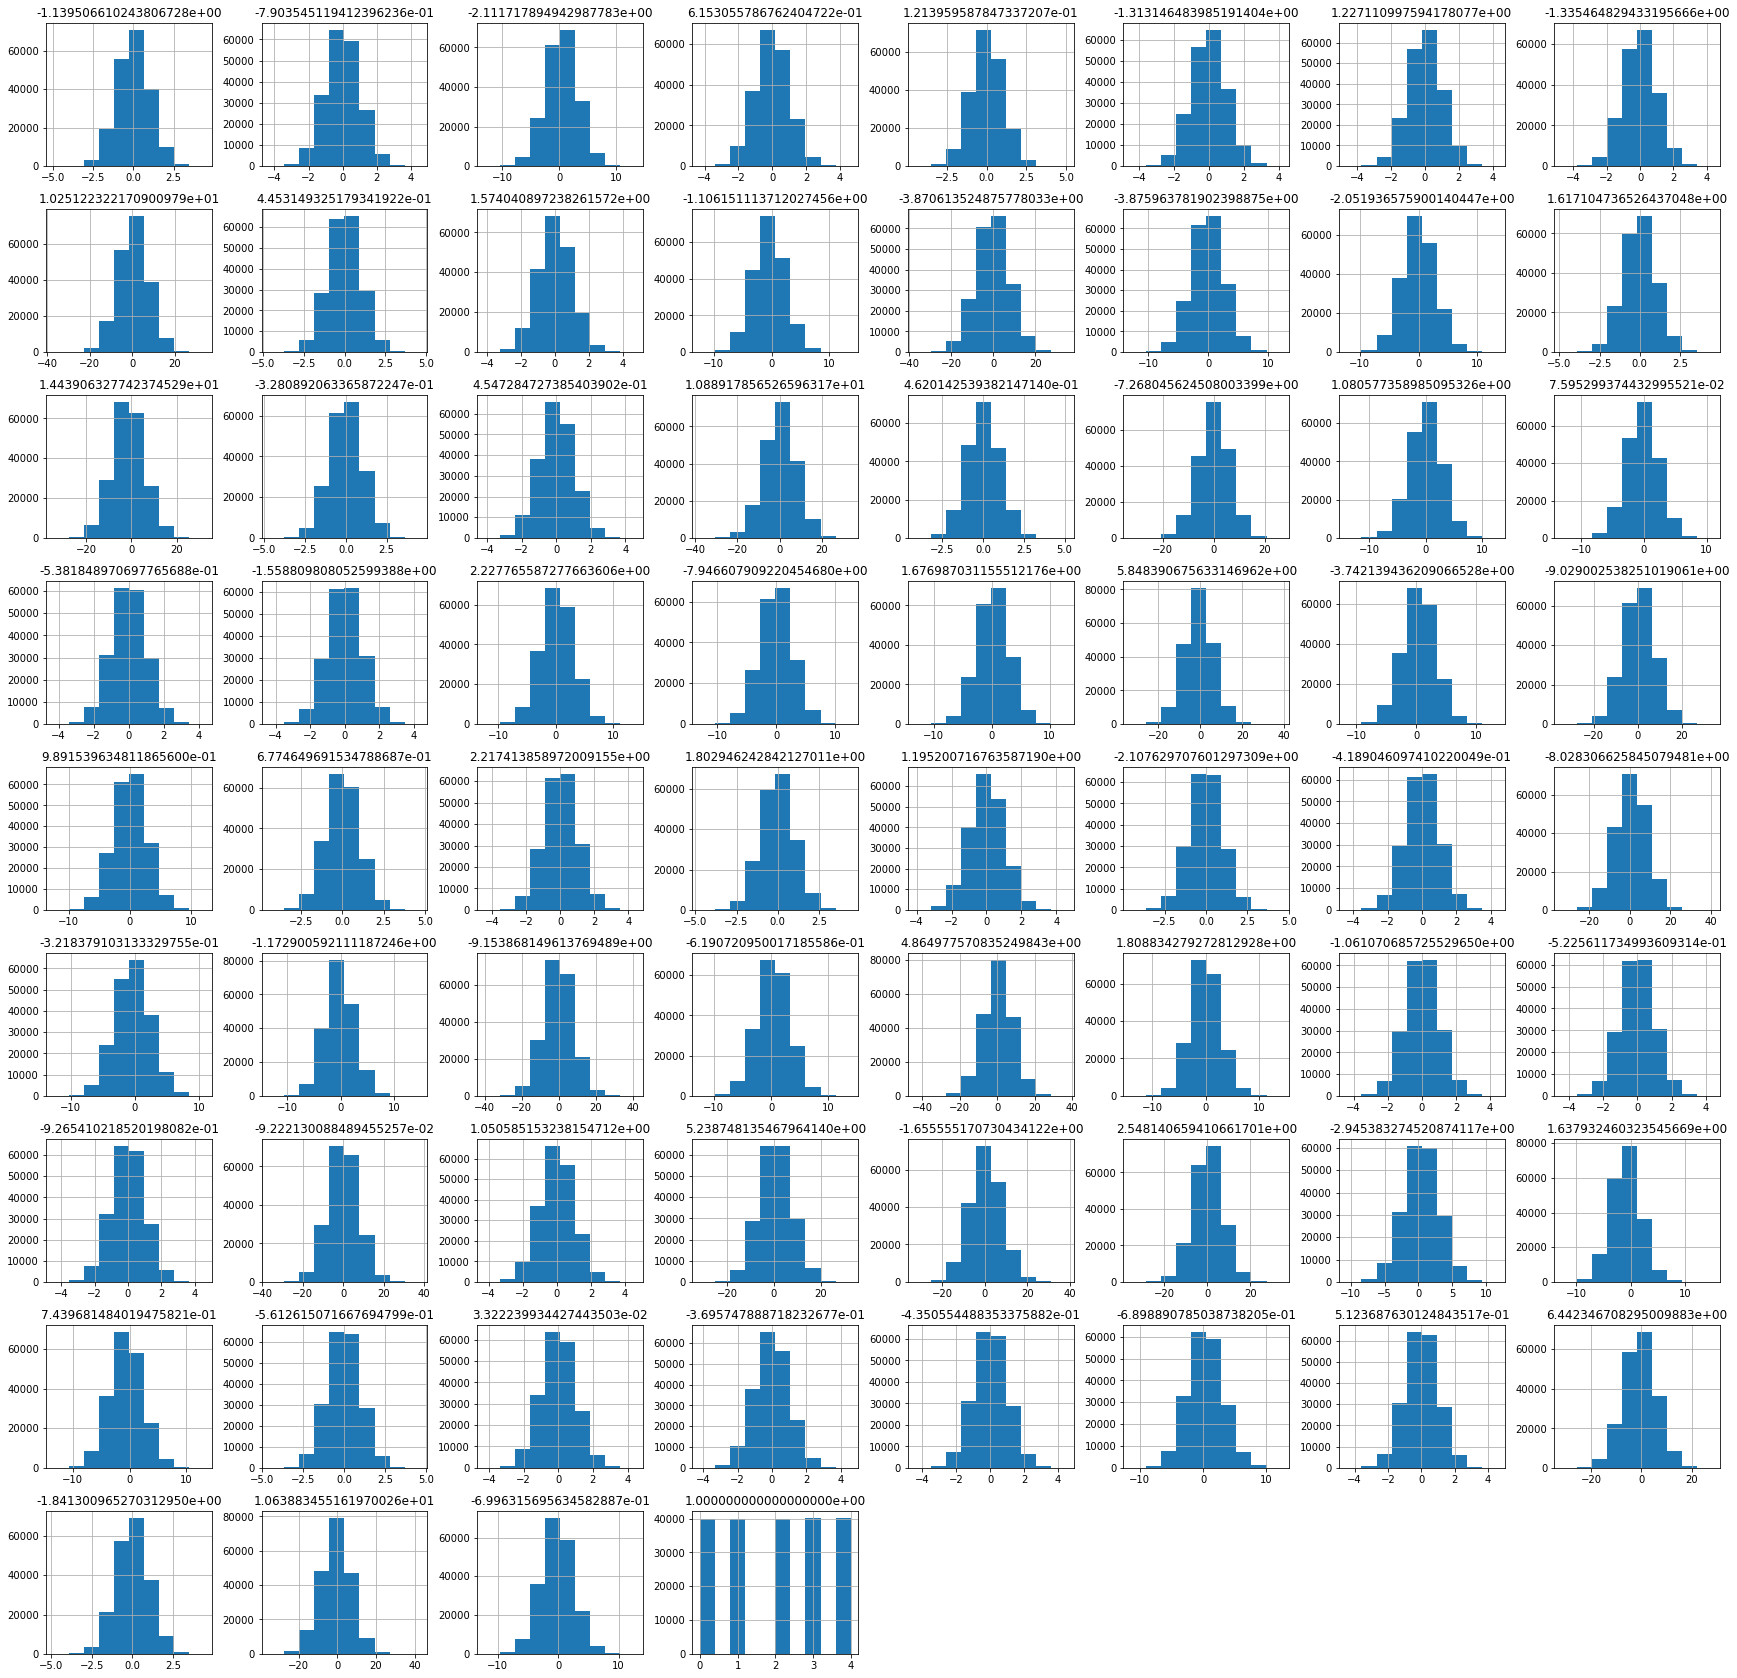

In [7]:
plt.rc('font', size =10)
data.hist(figsize=(30,30))
plt.show()

The data is in a Gaussian distribution, which is to be expected.

In [8]:
print(data.isnull().values.any())

print(data.isnull().sum().sum())

False
0


This is to confirm there is no missing data

In [9]:
print("Correlation Table")
data.corr().unstack().sort_values().drop_duplicates()

Correlation Table


-8.028306625845079481e+00  1.025122322170900979e+01    -0.636136
-3.870613524875778033e+00  2.548140659410661701e+00    -0.613014
1.088917856526596317e+01   -9.153868149613769489e+00   -0.501329
-9.029002538251019061e+00  4.864977570835249843e+00    -0.471920
1.080577358985095326e+00   6.442346708295009883e+00    -0.471378
                                                          ...   
5.848390675633146962e+00   1.063883455161970026e+01     0.481444
1.637932460323545669e+00   -3.870613524875778033e+00    0.484923
-9.153868149613769489e+00  -2.051936575900140447e+00    0.524017
5.848390675633146962e+00   -9.222130088489455257e-02    0.583914
-1.139506610243806728e+00  -1.139506610243806728e+00    1.000000
Length: 2279, dtype: float64

This is dropping any duplicate data.

# Data Pre-Processing

Normalizing the data. This is to is to change the values of numeric columns in the dataset to use a common scale, without altering the differences in the ranges of values or losing data. We could detect outliers in the visual using the histogram but did not see any of these

In [10]:
X = X / X.max(axis=0)
# enocde values to categorical from Int.
encoded_y = to_categorical(y)

# Model Exploration To Determine Network Topology


In [ ]:

# define and fit the final model
model = Sequential()
model.add(Dense(50, input_dim=67, activation='relu'))
model.add(Dense(5, activation='softmax'))


model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=10)


# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Investigation 1:** We can see that the network is suffering overfitting after around 10 epochs of learning. The train set has quickly trained with a low amount of loss. The test set is suffering from low accuracy and high loss. This means the model is making bad predictions on data it has never seen before.

We will continue to use the data split, to determine overfitting and underfitting in our model. The activation function being softmax because this is a multi-class classification problem where we need to normalize the output of the network over several predicted output classes.

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(100, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(50, kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=10)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Investigation 2:** 
I added a extra layer to see if it makes a different to capacity and depth of the network and we can see that it does. 

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(2000, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(500 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=10)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Investigation 3**

This investigation we are increasing the capacity while ensuring to observe the accuracy while not relying to much on loss. This graph does show higher overfitting as the model loss train and test sets diverge after first epoch.

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(2000, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1500 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(800 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=10)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Investigation 4**
This again increases the depth and capacity of the network. I have added 3 hidden layers between the input and output layers. It does improve accuracy a small bit but starts to show overfitting. The model is learning to well with the layers at the moment where it is negatively affecting the data. 

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1900, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1300 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(700 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=5)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Investigation 5**
For this investigation I decreased the capacity of the network and increased the depth of the network and I have also decreased the number of epochs in the training set. The training data seems to decrease rapidly after the first epoch for the model loss.

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=5)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Investigation 6**
This investigation decreases the capacity of the network. Keeping the hidden layers to see if can get better result which we can see after the third epoch the val_acc and val_loss is small bit better. There is still a small bit of overfitting but this can be reduced.

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(100 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=4)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Investigation 7**
Again I have increased the capacity and depth to the network. Ive added another hidden layer to try get a better result reducing the epcohs to 4. The training set is performing better than the test set compared to the previous investigation. Unfortunetly the test set is what matters so we need to sort this out with the layers.

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1400, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=10)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Investigation 8**
Decreasing the depth and capacity, I have removed the the hidden layer I added in Investiation 7 and added the epochs to 10. The overfitting again occurs around the fourth or fifth epoch. The accuracy is around the 63% to 65%. With accuracy being key I need to develop the model better around that.

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(800, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(400 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=10)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Investigation 9**
Similar to previous investigation but there is less accuracy and more loss.

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(700, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(300 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(100 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=5)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Investigation 10**
We can see that the model is performing better with the loss being lower and the accuracy being higher but leveling out around the 64%-65% mark. 

# Initial Hyperparameter Investigation

**Batch Size: 64, Epochs: 10**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=10,batch_size=64)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Batch Size: 128, Epochs:15**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=15,batch_size=128)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Batch Size: 256, Epochs: 20**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=20,batch_size=256)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Batch Size: 512, Epochs: 25**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=25,batch_size=512)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Batch Size: 1024, Epochs: 30**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=30,batch_size=1024)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Batch Size: 2048, Epochs: 35**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=35,batch_size=2048)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Batch Size: 4096, Epochs: 40**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=40,batch_size=4096)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Batch Size: 8192, Epochs: 45**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=45,batch_size=8192)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Selected Batch Size and Epoch

 **I choose Batch Size 128 and Epoch 3 , as i feel its performing**



# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=3,batch_size=128)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
**Batch Size 32, Epoch 3 as default**

Epoch 1/3
4188/4188 [==============================] - 88s 21ms/step - loss: 1.2456 - acc: 0.5783 - val_loss: 1.1773 - val_acc: 0.6215
Epoch 2/3
4188/4188 [==============================] - 91s 22ms/step - loss: 1.1527 - acc: 0.6351 - val_loss: 1.1567 - val_acc: 0.6322
Epoch 3/3
4188/4188 [==============================] - 91s 22ms/step - loss: 1.1331 - acc: 0.6462 - val_loss: 1.1478 - val_acc: 0.6410


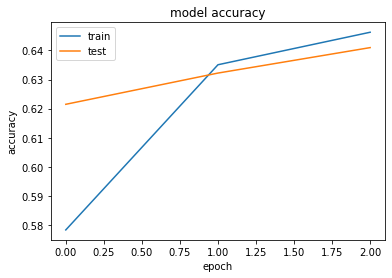

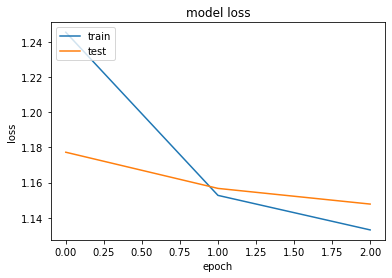

In [11]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=3)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Optimisers**

**SGD**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))


# Compile model
opt = SGD(lr=0.01, momentum=0.9, decay=0.01)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=3)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**ADAGRAD**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adagrad", metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=3)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**RMSPROP**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="rmsprop", metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=3)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

**Adam**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=81, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer"adam", metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=3)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Grid Search**

In [ ]:
# Function to create model, required for KerasClassifier
def create_model(optimizer='adam', init='uniform'):
    # create model
  model = Sequential()
  model.add(Dense(1600, input_dim=67, kernel_initializer=init, activation='relu'))
  model.add(Dense(1000 ,kernel_initializer=init, activation='relu'))
  model.add(Dense(200 ,kernel_initializer=init, activation='relu'))
  model.add(Dense(200 ,kernel_initializer=init, activation='relu'))
  model.add(Dense(5, kernel_initializer=init, activation='softmax'))
    # Compile model
  model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
  return model

# create model
model = KerasClassifier(build_fn=create_model, verbose=1)

# grid search epochs, batch size and optimizer
optimizers = ['adam', 'rmsprop', 'adagrad']
inits = ['uniform', 'normal']
epochs = [3, 5, 8, 11]
batches = [32, 64, 128, 256]

param_grid = dict(optimizer=optimizers, epochs=epochs, batch_size=batches, init=inits)
grid = GridSearchCV(estimator=model, param_grid=param_grid)
grid_result = grid.fit(X, encoded_y, verbose=1)


# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']

for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

This took very long to run using grid search to find the best model

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=3,batch_size=256)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Final Model**

In [ ]:
# define and fit the final model
model = Sequential()
model.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
model.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['acc'])
results = model.fit(X, encoded_y, validation_split=0.33,epochs=3,batch_size=256)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# **Unseen Data**

In [ ]:
# fix random seed for reproducibility
np.random.seed(93)
tf.random.set_seed(93)

features = 67
classes = 5
n = 30
errors = 0.42
redundant = int(features/4)



# Classification dataset
X, y = make_classification(n_samples=n, n_classes=classes, n_features=features, \
                           random_state = 1,n_informative =20, flip_y=errors, \
                           n_redundant=redundant)

# reshape y to 2D array, it needs to be to append
y = np.reshape(y, (-1, 1))

#add y to x
Xy = np.concatenate((X,y),axis=1)

np.savetxt("MyUnSeenData.csv", Xy, delimiter=",")

print(Xy[:5])

In [ ]:
testData = np.array([[-2.985416357671438092e+00,-4.012424770129491280e-01,4.350498839483707414e-02,-8.064253009978225251e+00,-3.282994895263450785e-01,2.154237605260652000e+00,1.843788268575589528e+00,2.298162466694352979e+00,-1.728443400200121438e-01,4.551516857562931118e-01,-3.734824027498927917e-02,2.312174577897027739e+00,-6.312586685319916846e+00,-3.547768982612266586e-01,-1.457681177312048604e+00,-6.725752046194750644e-01,3.292546368901791976e-01,-3.313066977047359085e+00,-2.462943962563002298e-01,-6.909195742166460708e-01,4.682654109935149300e-01,8.040515451896908417e+00,6.314632317657078442e-01,-8.481581789012491157e-01,-4.732752622932372144e-02,4.696451303762301244e-01,2.553148854536591017e-02,2.602760099456927545e+00,-5.595268399149126992e-01,9.925484586002815135e-01,-8.011885321670761950e-01,9.352519682727304939e+00,-1.204938018385665721e+00,-5.982147937763881984e-01,5.308316053129906287e+00,1.648992308132316786e+00,1.254784270285668413e+00,-8.723276714375659324e+00,3.153785654962081852e-01,-5.292851617610430104e-01,2.894282892231972437e-02,-6.229537618978953084e+00,6.295381629862458972e+00,-1.004418526028443281e+00,-7.770945950406845881e+00,-5.392660119272599806e-01,-1.185407789170237258e+01,-5.804699256117810791e+00,-5.456193111350698288e+00,-7.698072233255276453e-01,1.210551980001451478e+00,-1.399030888924924554e+00,1.984074132650088362e+00,4.271466381575259597e+00,-2.176761244994119160e+00,1.036085867217385381e+00,5.165008131169992328e-02,-1.992181804603951334e-01,-3.496307208399348720e+00,-3.499883056415922788e-01,1.686353634275729929e+00,9.951765675076230666e-01,3.989304918538058575e-01,-1.094394171229506219e+00,-7.095547765263172657e-01,-1.296588152416295880e+00,1.246221026989545733e+00,-7.545962410540477672e-01,1.707785365258823074e+00,7.454699901550868590e-01,1.201575015619208653e+00,1.058372268981606190e+00,-3.432452593973386867e-01,1.463360009576637477e+00,1.595991656762564548e-01,-5.868958621006730603e+00,-4.310605882354018870e-01,-4.596343842967440252e-01,-1.455420346519786134e+00,-6.616798321855954512e+00,9.915394384983994058e+00],
[5.760754012897320919e+00,4.306668296024491305e+00,2.374663934277295718e-01,2.295977391484597341e+00,7.862918934933967874e-01,-1.877142187179975386e-01,1.397010060056745329e-01,-3.858565877941179778e+00,8.074939696255074573e-01,9.390806687807043973e-01,-1.124033898911461909e-01,1.304683793253727409e+00,-7.640554496986282640e-01,9.140022974948493195e-02,-4.890201072937892524e-01,3.639321447151572797e-01,-9.853830741421629735e-01,-3.417135661818840209e+00,2.681596969494350891e-01,3.438632133974825145e+00,-2.413568114270807197e+00,4.907114006092097469e+00,-7.622249379410465063e-03,2.465194608863366943e-01,-7.443266299336349645e-01,-8.426038897107034353e-01,-1.550542936000105509e+00,-2.218136742858014543e+00,8.123368829104893329e-01,-3.378083793850470418e+00,6.424615235192521201e-01,1.754518969467263156e+00,-1.090607024847733086e+00,-4.179369905977352306e-02,4.115624322094999649e-02,-1.481979412324951895e+00,5.552884662443501040e-02,3.996494844327448615e+00,-6.207444344359481780e-01,-2.839725079798061991e+00,-1.471964694066517643e+00,1.506106426989897829e+00,9.621339581145263997e-01,9.881617888475106026e-01,3.905811924624775777e+00,6.833345347782964208e-01,3.008987933284413163e+00,2.240273482243638536e+00,1.147350734231159963e+00,8.897890624052434694e-01,2.791396522045436895e-02,-4.221504206503698065e+00,6.849393702796801042e-01,4.153652201180122461e-01,3.083895935782620334e+00,2.006628144561350080e+00,1.935510301180463300e+00,-1.231704726633345570e-01,3.337499904759469338e+00,1.503200435581389049e+00,-5.699971932923106888e-01,-2.963786752007175340e-01,-6.918888709443663521e-01,-8.365669056352954547e-01,-7.668206563310357993e-01,2.652278929682597042e+00,-5.597308791060695565e-01,3.713784101246172531e-01,-3.980914252991265556e-01,-5.698870000382182388e-01,1.387652012756414137e-02,-1.387113959395988250e+00,7.662133664401396538e-02,7.052355601766979731e-01,-1.492703745848704910e+00,-2.355495087501323637e-01,-5.463342013315357348e-02,-1.673864579346229009e+00,1.040803495201791051e+00,-3.065315751058558025e+00,-8.411046317779881321e+00],
[1.050026487820463572e+01,-2.379217623758863365e+00,3.528556101897828423e-01,7.962681812437227613e+00,-4.430168045941828003e-01,6.875876943313844469e-01,1.093487502754137836e-01,5.233514177682065949e+00,-7.305850578112021987e-01,8.866298459311623414e-01,-8.042861656640171164e-02,-1.827801631837707164e-01,1.402289239569707036e+01,1.227279842913046481e+00,-6.507351521387333415e-02,-7.979063831013835095e-01,-7.159251747537909161e-02,6.977220934267045038e+00,3.806043960280033334e-01,-3.019568696997298574e+00,1.310698689832733521e+00,2.636280946417685289e+00,-1.341075234499919944e+00,2.589332518802187760e-02,1.167753666322188799e+00,1.133484167291608724e+00,3.120897068749953540e+00,1.933869422240295233e-01,-1.942905920875912518e+00,-2.781336499634458725e+00,1.328001733520268735e-01,8.008025469533073704e+00,-3.100681081924015814e+00,2.095340483901188440e-03,-1.194854491071110525e+00,-2.722851251976985409e+00,7.178133684053337182e-01,-5.554445254439232649e+00,-3.990052632806517785e+00,2.606275263864195058e-01,-2.016538836607028595e-01,9.312033779937546996e+00,1.459506484352889988e+00,1.408217331593034083e-01,4.854377587035090258e+00,-1.211989928208227374e+00,-4.922693797304917851e+00,3.139295048647821051e+00,9.248752737038179461e+00,1.086378447015136084e+00,6.870380565998115419e-01,-6.727324417760700559e-01,1.018470852254898418e+00,-2.154554675122566376e-01,-5.387349938023400675e+00,-7.269286518151497622e-01,-1.082261643455897406e-02,-6.224574612252108397e-01,-2.270151541185027710e+00,4.840979698678788551e-02,-1.582781350879636229e-01,7.343142380546093584e+00,-1.124796696465733659e+00,-9.533528148030201432e-01,-1.245473236302047759e+00,-6.397845655974068180e-01,-1.142013932763954687e+00,-9.630014233429489146e-01,-4.647787085563956921e-01,-6.588434976465022685e-02,3.355961513610497549e-01,-4.394358886191839453e+00,1.107073911489380169e+00,2.400360459503049437e+00,1.332659707360353440e+00,3.233537216282749149e+00,4.983709787944293756e-01,-5.745795417285818329e-01,2.635182202432777121e+00,4.241518273589928611e+00,2.136172893398888384e+00],
[-6.415491921765733574e-01,-2.712567979055291456e-01,-4.623416190153337713e-01,9.212628941425168305e-01,-1.552216814207568740e+00,2.084513922928348251e-01,-1.293925047081115887e+00,2.107507933598785410e+00,-1.126432741412030980e+00,4.699935961513764145e-03,-1.703785049926676898e+00,-1.050224317829875798e+00,-7.623942310775095876e+00,1.753508448678423037e-01,3.683333828955280276e-01,1.320924734275046308e+00,-6.780403060118187497e-01,1.146462867326882712e-02,1.436176677723674411e+00,4.401959764480094961e+00,-4.355741714962380051e-01,4.135256963811484443e-01,-3.036252520815734823e-01,-8.321906738479518673e-01,2.610765381730812199e-02,-1.036870061266861542e+00,-3.406331062526999354e-01,-2.308022290828133372e-01,2.268319409925220853e+00,1.563129668421412211e+00,1.063536147266354259e+00,2.444733869580148600e+00,-3.118234171924679998e+00,4.559104757802749375e-01,-8.670733887174938204e+00,-1.300958632311047580e+00,1.161552096953374802e+00,-5.438946905671182996e+00,2.643546889998576788e+00,3.161771591633775635e+00,-1.412855723129405883e+00,-6.267807833376612514e+00,7.296309049370572453e+00,-1.217838671215705215e+00,2.777121856410542655e+00,5.717831500153967017e-01,-3.231767540898960789e+00,-2.400902214267036427e+00,-5.743324821976165673e+00,-4.938724500901424674e-01,1.803932950047493211e-01,2.749419111637434465e+00,1.626452525932492454e+00,3.665640182881438891e-01,-1.128760103532271408e+01,-1.718030829561559151e-03,5.843129656524639892e-02,3.020114884341724149e-01,-3.934077741688630780e+00,-1.919626136580503684e-01,-1.665440070574283116e+00,-2.372321494651063567e+00,1.946941391199768778e-01,-1.118365489319802286e+00,-1.576657939867898595e+00,-1.251009261468650768e+00,1.578095129679257136e+00,-6.303167179427487943e-01,-2.052507009369989532e+00,1.295956536200149944e+00,2.792683590841139596e-01,1.358385939894191097e-01,-5.528702478849655266e-01,1.996706455805361768e+00,-1.403572486866725422e+00,8.371815629337806541e-01,1.730491527005957986e+00,-1.219226364707353794e+00,-3.958237759863589833e+00,1.460310939558167487e+00,-3.097085887418787209e+00],
[3.367404302886161105e+00,4.348467241455558963e+00,-6.220402717488450195e-01,-1.603269692068834518e+00,-1.429457066934292753e+00,-3.990954971665289924e-02,3.615725010882979151e-01,1.107697256588936696e+00,-5.655824605382080428e-01,1.689152672494124374e+00,-1.044125827866027034e-02,-5.678691222232413738e-01,-4.165150447765372910e+00,-5.895011638865148562e-01,9.781187573165862625e-01,1.866949141490745756e-01,9.496600455258216167e-01,-7.256845084565285653e+00,1.015553043263723643e+00,-3.612293064486791216e-01,-1.618453730541940416e+00,1.889184449881577521e+00,2.933294672243462187e-01,-1.236135162967397338e+00,5.736466856995304786e-01,-1.818958714360024986e+00,2.796758696883574924e+00,-1.102899655010896485e+00,-3.409352279724905177e+00,-2.767319855354995362e+00,-2.186815908106751749e+00,1.410136385206787324e+01,3.832785134482224798e+00,4.534360811813268333e-01,1.065169808873551105e+01,-1.302476152344278493e-01,2.941597839913615564e-01,9.838507269897020180e+00,6.626042575162957249e+00,1.507946847274192592e+00,-1.319879269903766916e+00,7.889166333362089389e+00,-5.909678968362044316e+00,2.056731254261348063e+00,7.561531613850458022e+00,-1.079986789809565639e+00,5.999961507590484189e+00,2.608233090671975951e+00,6.247522044283956966e+00,3.028021507491707176e-01,-8.032988229912794154e-01,-1.477861228735099619e+00,6.982536005565727066e-01,1.560985471217621878e+00,3.517652056176776121e+00,6.681441107170537075e-01,1.444676067969658639e+00,1.135507396653411549e-01,7.678587244363344055e-01,-1.213504869194142577e+00,4.353788547738699499e-01,-1.202470120401148357e+01,5.814071798057131035e-01,-3.719710033329185483e-01,-4.075300638440280565e+00,-2.387808761728598572e+00,-4.546826878704784969e-02,2.071347881650793088e+00,1.883505693018204141e+00,-6.947821766785136077e-01,-1.833180488085587312e+00,-2.118782627576543121e+00,-1.613372729357742119e-01,-1.200579237095558582e+00,-1.559718407007905761e+00,-2.279233276779238260e+00,-8.506543208206648332e-01,5.909457311277808156e-01,-1.584158817722049362e+00,-5.345526612542066403e+00,1.032281179847173824e+01],
[-6.279519890486629841e+00,2.984678627241894588e-01,3.266678355449931792e-01,6.615433388664579084e+00,3.007970337952594053e-01,-4.495284070162376411e-01,1.413117739585306731e+00,2.631282645441882284e+00,9.920605530150810036e-01,6.238330988262129617e-01,-1.280818082630427214e-03,1.421046723123809696e-01,1.953774323070395225e+00,2.259120022339508940e-02,2.219756134237049205e-01,-4.600104967055327898e-01,-1.297875615471797195e+00,3.175963371624081155e+00,1.521229766962174157e+00,-1.495420702981965722e+00,1.582504312816721770e+00,-8.722252573877171677e-01,7.287758921241658250e-01,1.034833366103765639e+00,-6.876738372050350545e-01,1.338145136558061887e+00,1.297263428761574300e+00,-1.035367618998367600e+00,-3.166492217353618077e-01,2.410706495968426122e+00,8.202567997945232614e-01,-1.333339011945088748e+00,2.803614808851480067e-01,3.934369595035402400e-01,2.522152051219795688e+00,7.926605905243919725e-01,2.930083212386504155e+00,-2.617220009027022010e-01,1.589581684395886541e+00,1.230920391580736073e+00,-1.203347656286334576e-02,-1.591720246643377967e+00,1.003521328827616621e+01,1.288572511672076759e+00,3.245430312967507280e+00,-2.740350941144933383e-01,-3.887556813442970549e-01,4.953431405443965652e+00,7.223405762117097950e+00,3.301681809679333224e-01,7.950048994170415551e-01,-5.235982271440222657e-01,-8.336655811197551946e-01,1.671000291387305214e+00,1.156311646341782184e+00,8.048843169664202657e-01,4.072125362902245110e-02,1.230312245091659484e+00,2.330463968709258538e+00,-2.145841812691291206e-01,-2.615493251534693364e+00,-3.647776079740394639e+00,1.033702342466308544e+00,-3.617810222281976906e-01,6.729992073158377330e-01,9.908944161189933708e-02,-5.311009760544345149e-01,-4.109118838047800537e-01,1.601913212060251501e+00,1.039437992856676596e+00,2.106722686651326892e+00,-2.295357121985072357e+00,6.799861411587336812e-01,2.008205831526900909e+00,8.641140849502451093e-01,-4.211430628238119755e-01,-5.924669645774740534e-01,6.170541625063776653e-02,2.641120400256040224e+00,2.949085285826444469e+00,7.155945737293210485e+00],
[7.358096407040514819e+00,-1.406547311864178251e+00,-1.019720048404296087e+00,-1.248811640286220204e+01,1.121574063412345446e+00,4.528695546709248787e-01,1.634358485664579863e+00,-3.774731198290155021e+00,1.021028761672571950e+00,1.905852107505038973e+00,-7.528371845419303821e-01,-1.064437375681123621e+00,-7.225958897424630933e+00,4.021722715859418762e-01,1.701796671574662412e+00,-3.878879894667282974e-02,3.749580892395692477e-01,-2.985216779915957019e+00,3.312981449876042928e-01,-1.210090801926893445e+00,3.029632899952883207e-01,6.405451913619161886e+00,7.034482370778747384e-01,2.683901565560963820e-01,6.812369647790720295e-01,9.616998547689277199e-01,1.306197463990186325e-01,3.379202890547928106e+00,7.861111327179926000e-01,-3.606983847510178975e-01,7.891898226405603956e-02,2.954220288882780210e+00,2.534713078940093123e+00,-1.162333987284100312e+00,7.775930435749954128e+00,-3.936897542869993494e+00,1.625898464451382697e-01,-5.302299276557316254e+00,-5.717668406705094242e-01,1.864841140255953267e+00,-2.675767174402450821e-01,-2.037182711308128447e+00,1.569774307974232785e+00,-5.882569969035251756e-01,-4.663357616321308630e-01,2.775070459022593861e-01,-5.055413539047176386e+00,-2.825169537511686979e+00,-6.646245819859275095e+00,7.639147277022015903e-01,1.931398733532420753e+00,6.238157950077527492e-01,-1.719943867578976215e+00,2.836055557313241771e+00,-4.639558377419424673e+00,-3.060639959868370341e-01,-2.224743043400328801e+00,5.949761627368765904e-01,-1.911040808062054897e+00,5.563078561562034841e-02,4.058759127700994895e+00,5.151326336733881739e+00,-1.331991819377565278e+00,1.773036872872523873e+00,-4.011857107217191576e+00,8.272080744008796227e-01,-1.441148420844021727e+00,5.066306767822029711e-01,-1.072251794409545766e+00,-3.160693813164583421e-01,-1.949810689215709214e+00,-7.360207607019737530e-01,1.089142266218482424e+00,-3.433559079267027414e+00,-1.747202102247095157e-01,-4.200106455828734653e+00,3.379239933097898385e-01,-2.630553203217758096e-01,-3.067300594473210129e-02,-6.213851312244708325e+00,9.563813998792319637e+00],
[-3.611219394266497407e+00,-3.444875914010243179e+00,2.469779193615914692e-01,1.188551820617146859e+01,-3.404142699188507093e-01,7.825091696591285340e-02,6.101147912779490978e-01,-7.158308880616627512e+00,5.941174632459419458e-01,-1.192212902668710495e+00,-1.107620460034509403e-02,4.856815909893212879e-01,6.418761986086766846e+00,3.336926862664608140e-01,1.049341755444827440e+00,-1.316679704315916855e+00,-1.683941541056688473e+00,-9.280812687528841920e+00,5.487521940160408063e-01,3.823951287463711601e-01,-6.009831398994478491e+00,-1.320915988872922497e+00,4.765987240833631788e-01,1.275966877795021992e-01,-4.380951616989381403e-01,-3.755812669314532171e-01,3.397320027823374833e+00,-3.829591084071226170e+00,-1.517362228070597396e+00,-3.524227697354635591e+00,6.294120903700577419e-01,-1.163179002205287027e+01,4.086723402684263595e-01,-2.472149545065386866e-01,4.184036730970914775e+00,1.549394180113072839e-01,8.802110189694060116e-01,1.372207115283297618e+01,-4.426869772449466001e-01,4.223957180937905065e-01,-1.017311422818940603e+00,1.681463088341425216e+00,-5.021872456382365790e+00,1.891705188611696176e-01,1.035224961189146597e+01,-1.941985153668302821e+00,6.764738477301384556e+00,1.305765614099194671e-01,1.235111451675840399e+01,-3.343178874886175711e-01,-1.088870275390664943e+00,3.715778604620537884e+00,4.149065283796035675e-01,1.079852810983268352e+00,-4.560188587881073730e+00,8.606325503135665578e-01,1.752312456466462720e+00,1.176208061409850236e+00,3.199525908973977817e+00,-2.834400642575207296e+00,-3.468397354196186111e+00,-6.467953993658970280e-01,-3.865542197384919665e-01,-6.155852250344889809e-01,1.396262036836168452e+00,8.050879973020380609e-01,-1.034029260880297896e+00,7.710008128414419515e-01,1.440192312917337070e+00,-3.477340520776726618e-01,-1.244446869198632954e-01,1.035155490751562546e+00,1.139412156147674438e+00,4.176499028477998365e+00,8.676390027296279062e-01,3.346233807002526817e+00,-1.450006570700336672e+00,-7.951725666313227969e-02,2.309399108211589891e+00,5.312490112735106962e+00,-1.709192307559391111e+01],
[-9.665959517060624950e-01,-4.140960158291108861e+00,2.565643279949862965e-01,-4.186482507341334980e+00,9.904661803414933907e-02,1.075179500445744729e+00,1.432810145963814730e+00,1.487715068872580915e+01,-9.051001690350845008e-01,2.400857397430970069e-02,5.614771311209921789e-01,-2.722476474474396224e-01,8.968310659799857421e-01,3.852861380157715510e-01,3.860310927403783066e-02,7.580731899185761957e-01,5.064604960492889996e-01,1.325217236189108760e+01,8.686357880964894473e-01,3.232520737642527564e+00,6.862075519893300335e-01,1.937066393314700008e+01,-2.748096267946008586e-01,-1.508076893876228786e+00,3.414367033547154873e-01,6.876007435946345225e-01,7.991076459814398625e+00,-1.141396976531523499e-01,3.702617114471580706e+00,5.520595953793821842e+00,7.084340708498865213e-01,-3.157657762946026292e+00,1.895347628489014724e-01,-9.128972367857814962e-01,1.221912764127726270e+01,3.461666708911566914e+00,-1.909360479041678493e-01,8.071296053949774674e+00,1.104304421245283052e+01,-4.355420894568514889e+00,4.628718942494904065e-02,-8.915423911286913139e+00,8.304443022778967176e+00,1.480063037162940021e-01,-1.635151998361390113e+01,3.838243428641085475e-01,-1.534477231043476664e+01,-3.814128357716381146e+00,-1.054047840475901054e+01,9.151271204830440098e-01,-1.049526009818735339e+00,-4.573740248217847970e-01,-2.967290703920111294e-01,5.318281502560251894e+00,-6.210347446281567763e+00,-8.603367504157015677e-01,-2.853478030013680389e+00,-8.378892359585571326e-01,-1.472877328187951473e-01,1.587586936516102720e-01,-1.810356160022110750e+00,-3.368130039138780507e+00,-8.686692139073252106e-01,-4.806157967923737617e-01,3.113385826658632283e+00,-1.135451147960860219e+00,-2.326530939087446015e+00,1.526626312053527945e+00,-1.978604213756854691e+00,-1.814308677172372208e+00,2.262875395459054140e+00,2.159928334197978472e+00,8.129021217512714115e-01,-5.476627149202421663e+00,-6.717906110362008576e-01,-1.402505739045482702e+00,9.613868525370181661e-01,3.500053778387274966e-02,-5.530896884420524184e-01,2.319570866900234396e+00,-1.946294647458461213e+01],
[4.152582253773534404e+00,5.541457073445649861e+00,-5.863145590215056435e-01,5.992750792817552963e+00,1.277382291569305162e+00,-8.720932216779221369e-01,5.366531847456252891e-01,2.797361481268594741e+00,-1.093667351389150832e+00,2.106032953212626790e-01,1.173216877381775936e+00,1.581832180260145160e+00,3.405063845064361661e-01,6.419554889332711456e-01,2.936216160917669016e-01,5.158595431683424826e-01,1.848176893203589966e-01,-5.743874746279010957e+00,-3.072506317303939638e-01,-2.863036188951371575e+00,-3.087696392585796534e+00,-1.139619768818152323e+01,2.379663614699825125e+00,1.173672087898597782e+00,7.101426177549771124e-01,-7.472727983324122247e-01,2.612901840679151100e+00,-4.291598614947710999e+00,-1.638370602938073795e+00,-1.202092229323288297e+00,-1.581000568577286547e+00,3.920329436730711770e+00,2.713882542121315300e-01,1.444055549652848880e+00,1.432763427371264386e+00,5.102442562994371489e-01,5.697866315807943449e-01,1.272437612335974144e+01,1.796590115907254059e+01,5.471159344997549745e+00,7.541369683243064059e-02,3.478089376140551803e+00,-1.616497922293291367e+01,-4.000053865132360831e-01,1.624565204140312247e+01,1.539693062115862876e+00,1.316765402413070341e+01,-1.644010532570259997e+01,9.750900232749266650e+00,-2.685592482563316508e-01,-1.235814982983165944e+00,4.351306074617692587e+00,-1.010842870493512402e+00,-3.201213314157948631e+00,7.786295655792891068e+00,1.559983801926228653e+00,1.602677603153122299e-01,1.693065674378285923e+00,-3.420453493210956708e+00,-1.559076493814998132e+00,-2.328398897462827577e+00,-7.430378337472516748e+00,-3.107342093563513208e-01,6.644702393172540189e-01,1.197974834692656199e+00,4.220790079043734155e-01,3.529436985870675336e-01,9.398179904707554266e-02,-2.050120806133185702e+00,5.184181204735690551e-01,-7.716509742284924922e-01,3.636461515298829550e+00,-1.925685006751600037e+00,-3.143613155907404977e+00,-1.678205857643203291e+00,-1.614143382140869054e-01,-5.655340609112921024e-01,6.753330739338895272e-01,2.554346790676083501e+00,6.876754653017621344e+00,2.964327438309982021e+00]
], dtype=float)


#Normalize data
testDataN = testData / testData.max(axis=0) #Necessary because we have normalized our data for training, we also need to normalize unseen data too.

prediction = modelF.predict_classes(testDataN)

print("Prediction 1, expected value is 2: ", prediction[0])
print("Prediction 2, expected value is 4: ", prediction[1])
print("Prediction 3, expected value is 3: ", prediction[2])
print("Prediction 4, expected value is 4: ", prediction[3])
print("Prediction 5, expected value is 1: ", prediction[4])
print("Prediction 6, expected value is 3: ", prediction[5])
print("Prediction 7, expected value is 2: ", prediction[6])
print("Prediction 8, expected value is 1: ", prediction[7])
print("Prediction 9, expected value is 2: ", prediction[8])
print("Prediction 10, expected value is 2: ", prediction[9])

# **Saving Model Weights**

In [ ]:
# define and fit the final model
modelF = Sequential()
modelF.add(Dense(1600, input_dim=67, kernel_initializer='uniform', activation='relu'))
modelF.add(Dropout(0.2))
modelF.add(Dense(1000 ,kernel_initializer='uniform', activation='relu'))
modelF.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
modelF.add(Dense(200 ,kernel_initializer='uniform', activation='relu'))
modelF.add(Dense(5, kernel_initializer='uniform', activation='softmax'))

modelF.compile(loss='categorical_crossentropy', optimizer="adam", metrics=['acc'])
results = modelF.fit(X, encoded_y, validation_split=0.33,epochs=4,batch_size=256)

# summarize history for accuracy
plt.plot(results.history['acc'])
plt.plot(results.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# serialize model to YAML
model_yaml = modelF.to_yaml()
with open("Production_Model_YAML.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
# serialize weights to HDF5
modelF.save_weights("Model_Weights.HDF5")
print("Saved model and structure")

**Opening model and weights and running model on new unseen data instance**

In [ ]:
yaml_file = open('Production_Model_YAML.yaml', 'r')
loaded_model_yaml = yaml_file.read()
yaml_file.close()

modelP = model_from_yaml(loaded_model_yaml)

# load weights into new model
modelP.load_weights("Production_Model_Weights.HDF5")
print("Loaded model and weights from disk")

testDataP = np.array([[-2.985416357671438092e+00,-4.012424770129491280e-01,4.350498839483707414e-02,-8.064253009978225251e+00,-3.282994895263450785e-01,2.154237605260652000e+00,1.843788268575589528e+00,2.298162466694352979e+00,-1.728443400200121438e-01,4.551516857562931118e-01,-3.734824027498927917e-02,2.312174577897027739e+00,-6.312586685319916846e+00,-3.547768982612266586e-01,-1.457681177312048604e+00,-6.725752046194750644e-01,3.292546368901791976e-01,-3.313066977047359085e+00,-2.462943962563002298e-01,-6.909195742166460708e-01,4.682654109935149300e-01,8.040515451896908417e+00,6.314632317657078442e-01,-8.481581789012491157e-01,-4.732752622932372144e-02,4.696451303762301244e-01,2.553148854536591017e-02,2.602760099456927545e+00,-5.595268399149126992e-01,9.925484586002815135e-01,-8.011885321670761950e-01,9.352519682727304939e+00,-1.204938018385665721e+00,-5.982147937763881984e-01,5.308316053129906287e+00,1.648992308132316786e+00,1.254784270285668413e+00,-8.723276714375659324e+00,3.153785654962081852e-01,-5.292851617610430104e-01,2.894282892231972437e-02,-6.229537618978953084e+00,6.295381629862458972e+00,-1.004418526028443281e+00,-7.770945950406845881e+00,-5.392660119272599806e-01,-1.185407789170237258e+01,-5.804699256117810791e+00,-5.456193111350698288e+00,-7.698072233255276453e-01,1.210551980001451478e+00,-1.399030888924924554e+00,1.984074132650088362e+00,4.271466381575259597e+00,-2.176761244994119160e+00,1.036085867217385381e+00,5.165008131169992328e-02,-1.992181804603951334e-01,-3.496307208399348720e+00,-3.499883056415922788e-01,1.686353634275729929e+00,9.951765675076230666e-01,3.989304918538058575e-01,-1.094394171229506219e+00,-7.095547765263172657e-01,-1.296588152416295880e+00,1.246221026989545733e+00,-7.545962410540477672e-01,1.707785365258823074e+00,7.454699901550868590e-01,1.201575015619208653e+00,1.058372268981606190e+00,-3.432452593973386867e-01,1.463360009576637477e+00,1.595991656762564548e-01,-5.868958621006730603e+00,-4.310605882354018870e-01,-4.596343842967440252e-01,-1.455420346519786134e+00,-6.616798321855954512e+00,9.915394384983994058e+00],
[5.760754012897320919e+00,4.306668296024491305e+00,2.374663934277295718e-01,2.295977391484597341e+00,7.862918934933967874e-01,-1.877142187179975386e-01,1.397010060056745329e-01,-3.858565877941179778e+00,8.074939696255074573e-01,9.390806687807043973e-01,-1.124033898911461909e-01,1.304683793253727409e+00,-7.640554496986282640e-01,9.140022974948493195e-02,-4.890201072937892524e-01,3.639321447151572797e-01,-9.853830741421629735e-01,-3.417135661818840209e+00,2.681596969494350891e-01,3.438632133974825145e+00,-2.413568114270807197e+00,4.907114006092097469e+00,-7.622249379410465063e-03,2.465194608863366943e-01,-7.443266299336349645e-01,-8.426038897107034353e-01,-1.550542936000105509e+00,-2.218136742858014543e+00,8.123368829104893329e-01,-3.378083793850470418e+00,6.424615235192521201e-01,1.754518969467263156e+00,-1.090607024847733086e+00,-4.179369905977352306e-02,4.115624322094999649e-02,-1.481979412324951895e+00,5.552884662443501040e-02,3.996494844327448615e+00,-6.207444344359481780e-01,-2.839725079798061991e+00,-1.471964694066517643e+00,1.506106426989897829e+00,9.621339581145263997e-01,9.881617888475106026e-01,3.905811924624775777e+00,6.833345347782964208e-01,3.008987933284413163e+00,2.240273482243638536e+00,1.147350734231159963e+00,8.897890624052434694e-01,2.791396522045436895e-02,-4.221504206503698065e+00,6.849393702796801042e-01,4.153652201180122461e-01,3.083895935782620334e+00,2.006628144561350080e+00,1.935510301180463300e+00,-1.231704726633345570e-01,3.337499904759469338e+00,1.503200435581389049e+00,-5.699971932923106888e-01,-2.963786752007175340e-01,-6.918888709443663521e-01,-8.365669056352954547e-01,-7.668206563310357993e-01,2.652278929682597042e+00,-5.597308791060695565e-01,3.713784101246172531e-01,-3.980914252991265556e-01,-5.698870000382182388e-01,1.387652012756414137e-02,-1.387113959395988250e+00,7.662133664401396538e-02,7.052355601766979731e-01,-1.492703745848704910e+00,-2.355495087501323637e-01,-5.463342013315357348e-02,-1.673864579346229009e+00,1.040803495201791051e+00,-3.065315751058558025e+00,-8.411046317779881321e+00],
[1.050026487820463572e+01,-2.379217623758863365e+00,3.528556101897828423e-01,7.962681812437227613e+00,-4.430168045941828003e-01,6.875876943313844469e-01,1.093487502754137836e-01,5.233514177682065949e+00,-7.305850578112021987e-01,8.866298459311623414e-01,-8.042861656640171164e-02,-1.827801631837707164e-01,1.402289239569707036e+01,1.227279842913046481e+00,-6.507351521387333415e-02,-7.979063831013835095e-01,-7.159251747537909161e-02,6.977220934267045038e+00,3.806043960280033334e-01,-3.019568696997298574e+00,1.310698689832733521e+00,2.636280946417685289e+00,-1.341075234499919944e+00,2.589332518802187760e-02,1.167753666322188799e+00,1.133484167291608724e+00,3.120897068749953540e+00,1.933869422240295233e-01,-1.942905920875912518e+00,-2.781336499634458725e+00,1.328001733520268735e-01,8.008025469533073704e+00,-3.100681081924015814e+00,2.095340483901188440e-03,-1.194854491071110525e+00,-2.722851251976985409e+00,7.178133684053337182e-01,-5.554445254439232649e+00,-3.990052632806517785e+00,2.606275263864195058e-01,-2.016538836607028595e-01,9.312033779937546996e+00,1.459506484352889988e+00,1.408217331593034083e-01,4.854377587035090258e+00,-1.211989928208227374e+00,-4.922693797304917851e+00,3.139295048647821051e+00,9.248752737038179461e+00,1.086378447015136084e+00,6.870380565998115419e-01,-6.727324417760700559e-01,1.018470852254898418e+00,-2.154554675122566376e-01,-5.387349938023400675e+00,-7.269286518151497622e-01,-1.082261643455897406e-02,-6.224574612252108397e-01,-2.270151541185027710e+00,4.840979698678788551e-02,-1.582781350879636229e-01,7.343142380546093584e+00,-1.124796696465733659e+00,-9.533528148030201432e-01,-1.245473236302047759e+00,-6.397845655974068180e-01,-1.142013932763954687e+00,-9.630014233429489146e-01,-4.647787085563956921e-01,-6.588434976465022685e-02,3.355961513610497549e-01,-4.394358886191839453e+00,1.107073911489380169e+00,2.400360459503049437e+00,1.332659707360353440e+00,3.233537216282749149e+00,4.983709787944293756e-01,-5.745795417285818329e-01,2.635182202432777121e+00,4.241518273589928611e+00,2.136172893398888384e+00],
[-6.415491921765733574e-01,-2.712567979055291456e-01,-4.623416190153337713e-01,9.212628941425168305e-01,-1.552216814207568740e+00,2.084513922928348251e-01,-1.293925047081115887e+00,2.107507933598785410e+00,-1.126432741412030980e+00,4.699935961513764145e-03,-1.703785049926676898e+00,-1.050224317829875798e+00,-7.623942310775095876e+00,1.753508448678423037e-01,3.683333828955280276e-01,1.320924734275046308e+00,-6.780403060118187497e-01,1.146462867326882712e-02,1.436176677723674411e+00,4.401959764480094961e+00,-4.355741714962380051e-01,4.135256963811484443e-01,-3.036252520815734823e-01,-8.321906738479518673e-01,2.610765381730812199e-02,-1.036870061266861542e+00,-3.406331062526999354e-01,-2.308022290828133372e-01,2.268319409925220853e+00,1.563129668421412211e+00,1.063536147266354259e+00,2.444733869580148600e+00,-3.118234171924679998e+00,4.559104757802749375e-01,-8.670733887174938204e+00,-1.300958632311047580e+00,1.161552096953374802e+00,-5.438946905671182996e+00,2.643546889998576788e+00,3.161771591633775635e+00,-1.412855723129405883e+00,-6.267807833376612514e+00,7.296309049370572453e+00,-1.217838671215705215e+00,2.777121856410542655e+00,5.717831500153967017e-01,-3.231767540898960789e+00,-2.400902214267036427e+00,-5.743324821976165673e+00,-4.938724500901424674e-01,1.803932950047493211e-01,2.749419111637434465e+00,1.626452525932492454e+00,3.665640182881438891e-01,-1.128760103532271408e+01,-1.718030829561559151e-03,5.843129656524639892e-02,3.020114884341724149e-01,-3.934077741688630780e+00,-1.919626136580503684e-01,-1.665440070574283116e+00,-2.372321494651063567e+00,1.946941391199768778e-01,-1.118365489319802286e+00,-1.576657939867898595e+00,-1.251009261468650768e+00,1.578095129679257136e+00,-6.303167179427487943e-01,-2.052507009369989532e+00,1.295956536200149944e+00,2.792683590841139596e-01,1.358385939894191097e-01,-5.528702478849655266e-01,1.996706455805361768e+00,-1.403572486866725422e+00,8.371815629337806541e-01,1.730491527005957986e+00,-1.219226364707353794e+00,-3.958237759863589833e+00,1.460310939558167487e+00,-3.097085887418787209e+00],
[3.367404302886161105e+00,4.348467241455558963e+00,-6.220402717488450195e-01,-1.603269692068834518e+00,-1.429457066934292753e+00,-3.990954971665289924e-02,3.615725010882979151e-01,1.107697256588936696e+00,-5.655824605382080428e-01,1.689152672494124374e+00,-1.044125827866027034e-02,-5.678691222232413738e-01,-4.165150447765372910e+00,-5.895011638865148562e-01,9.781187573165862625e-01,1.866949141490745756e-01,9.496600455258216167e-01,-7.256845084565285653e+00,1.015553043263723643e+00,-3.612293064486791216e-01,-1.618453730541940416e+00,1.889184449881577521e+00,2.933294672243462187e-01,-1.236135162967397338e+00,5.736466856995304786e-01,-1.818958714360024986e+00,2.796758696883574924e+00,-1.102899655010896485e+00,-3.409352279724905177e+00,-2.767319855354995362e+00,-2.186815908106751749e+00,1.410136385206787324e+01,3.832785134482224798e+00,4.534360811813268333e-01,1.065169808873551105e+01,-1.302476152344278493e-01,2.941597839913615564e-01,9.838507269897020180e+00,6.626042575162957249e+00,1.507946847274192592e+00,-1.319879269903766916e+00,7.889166333362089389e+00,-5.909678968362044316e+00,2.056731254261348063e+00,7.561531613850458022e+00,-1.079986789809565639e+00,5.999961507590484189e+00,2.608233090671975951e+00,6.247522044283956966e+00,3.028021507491707176e-01,-8.032988229912794154e-01,-1.477861228735099619e+00,6.982536005565727066e-01,1.560985471217621878e+00,3.517652056176776121e+00,6.681441107170537075e-01,1.444676067969658639e+00,1.135507396653411549e-01,7.678587244363344055e-01,-1.213504869194142577e+00,4.353788547738699499e-01,-1.202470120401148357e+01,5.814071798057131035e-01,-3.719710033329185483e-01,-4.075300638440280565e+00,-2.387808761728598572e+00,-4.546826878704784969e-02,2.071347881650793088e+00,1.883505693018204141e+00,-6.947821766785136077e-01,-1.833180488085587312e+00,-2.118782627576543121e+00,-1.613372729357742119e-01,-1.200579237095558582e+00,-1.559718407007905761e+00,-2.279233276779238260e+00,-8.506543208206648332e-01,5.909457311277808156e-01,-1.584158817722049362e+00,-5.345526612542066403e+00,1.032281179847173824e+01],
[-6.279519890486629841e+00,2.984678627241894588e-01,3.266678355449931792e-01,6.615433388664579084e+00,3.007970337952594053e-01,-4.495284070162376411e-01,1.413117739585306731e+00,2.631282645441882284e+00,9.920605530150810036e-01,6.238330988262129617e-01,-1.280818082630427214e-03,1.421046723123809696e-01,1.953774323070395225e+00,2.259120022339508940e-02,2.219756134237049205e-01,-4.600104967055327898e-01,-1.297875615471797195e+00,3.175963371624081155e+00,1.521229766962174157e+00,-1.495420702981965722e+00,1.582504312816721770e+00,-8.722252573877171677e-01,7.287758921241658250e-01,1.034833366103765639e+00,-6.876738372050350545e-01,1.338145136558061887e+00,1.297263428761574300e+00,-1.035367618998367600e+00,-3.166492217353618077e-01,2.410706495968426122e+00,8.202567997945232614e-01,-1.333339011945088748e+00,2.803614808851480067e-01,3.934369595035402400e-01,2.522152051219795688e+00,7.926605905243919725e-01,2.930083212386504155e+00,-2.617220009027022010e-01,1.589581684395886541e+00,1.230920391580736073e+00,-1.203347656286334576e-02,-1.591720246643377967e+00,1.003521328827616621e+01,1.288572511672076759e+00,3.245430312967507280e+00,-2.740350941144933383e-01,-3.887556813442970549e-01,4.953431405443965652e+00,7.223405762117097950e+00,3.301681809679333224e-01,7.950048994170415551e-01,-5.235982271440222657e-01,-8.336655811197551946e-01,1.671000291387305214e+00,1.156311646341782184e+00,8.048843169664202657e-01,4.072125362902245110e-02,1.230312245091659484e+00,2.330463968709258538e+00,-2.145841812691291206e-01,-2.615493251534693364e+00,-3.647776079740394639e+00,1.033702342466308544e+00,-3.617810222281976906e-01,6.729992073158377330e-01,9.908944161189933708e-02,-5.311009760544345149e-01,-4.109118838047800537e-01,1.601913212060251501e+00,1.039437992856676596e+00,2.106722686651326892e+00,-2.295357121985072357e+00,6.799861411587336812e-01,2.008205831526900909e+00,8.641140849502451093e-01,-4.211430628238119755e-01,-5.924669645774740534e-01,6.170541625063776653e-02,2.641120400256040224e+00,2.949085285826444469e+00,7.155945737293210485e+00],
[7.358096407040514819e+00,-1.406547311864178251e+00,-1.019720048404296087e+00,-1.248811640286220204e+01,1.121574063412345446e+00,4.528695546709248787e-01,1.634358485664579863e+00,-3.774731198290155021e+00,1.021028761672571950e+00,1.905852107505038973e+00,-7.528371845419303821e-01,-1.064437375681123621e+00,-7.225958897424630933e+00,4.021722715859418762e-01,1.701796671574662412e+00,-3.878879894667282974e-02,3.749580892395692477e-01,-2.985216779915957019e+00,3.312981449876042928e-01,-1.210090801926893445e+00,3.029632899952883207e-01,6.405451913619161886e+00,7.034482370778747384e-01,2.683901565560963820e-01,6.812369647790720295e-01,9.616998547689277199e-01,1.306197463990186325e-01,3.379202890547928106e+00,7.861111327179926000e-01,-3.606983847510178975e-01,7.891898226405603956e-02,2.954220288882780210e+00,2.534713078940093123e+00,-1.162333987284100312e+00,7.775930435749954128e+00,-3.936897542869993494e+00,1.625898464451382697e-01,-5.302299276557316254e+00,-5.717668406705094242e-01,1.864841140255953267e+00,-2.675767174402450821e-01,-2.037182711308128447e+00,1.569774307974232785e+00,-5.882569969035251756e-01,-4.663357616321308630e-01,2.775070459022593861e-01,-5.055413539047176386e+00,-2.825169537511686979e+00,-6.646245819859275095e+00,7.639147277022015903e-01,1.931398733532420753e+00,6.238157950077527492e-01,-1.719943867578976215e+00,2.836055557313241771e+00,-4.639558377419424673e+00,-3.060639959868370341e-01,-2.224743043400328801e+00,5.949761627368765904e-01,-1.911040808062054897e+00,5.563078561562034841e-02,4.058759127700994895e+00,5.151326336733881739e+00,-1.331991819377565278e+00,1.773036872872523873e+00,-4.011857107217191576e+00,8.272080744008796227e-01,-1.441148420844021727e+00,5.066306767822029711e-01,-1.072251794409545766e+00,-3.160693813164583421e-01,-1.949810689215709214e+00,-7.360207607019737530e-01,1.089142266218482424e+00,-3.433559079267027414e+00,-1.747202102247095157e-01,-4.200106455828734653e+00,3.379239933097898385e-01,-2.630553203217758096e-01,-3.067300594473210129e-02,-6.213851312244708325e+00,9.563813998792319637e+00],
[-3.611219394266497407e+00,-3.444875914010243179e+00,2.469779193615914692e-01,1.188551820617146859e+01,-3.404142699188507093e-01,7.825091696591285340e-02,6.101147912779490978e-01,-7.158308880616627512e+00,5.941174632459419458e-01,-1.192212902668710495e+00,-1.107620460034509403e-02,4.856815909893212879e-01,6.418761986086766846e+00,3.336926862664608140e-01,1.049341755444827440e+00,-1.316679704315916855e+00,-1.683941541056688473e+00,-9.280812687528841920e+00,5.487521940160408063e-01,3.823951287463711601e-01,-6.009831398994478491e+00,-1.320915988872922497e+00,4.765987240833631788e-01,1.275966877795021992e-01,-4.380951616989381403e-01,-3.755812669314532171e-01,3.397320027823374833e+00,-3.829591084071226170e+00,-1.517362228070597396e+00,-3.524227697354635591e+00,6.294120903700577419e-01,-1.163179002205287027e+01,4.086723402684263595e-01,-2.472149545065386866e-01,4.184036730970914775e+00,1.549394180113072839e-01,8.802110189694060116e-01,1.372207115283297618e+01,-4.426869772449466001e-01,4.223957180937905065e-01,-1.017311422818940603e+00,1.681463088341425216e+00,-5.021872456382365790e+00,1.891705188611696176e-01,1.035224961189146597e+01,-1.941985153668302821e+00,6.764738477301384556e+00,1.305765614099194671e-01,1.235111451675840399e+01,-3.343178874886175711e-01,-1.088870275390664943e+00,3.715778604620537884e+00,4.149065283796035675e-01,1.079852810983268352e+00,-4.560188587881073730e+00,8.606325503135665578e-01,1.752312456466462720e+00,1.176208061409850236e+00,3.199525908973977817e+00,-2.834400642575207296e+00,-3.468397354196186111e+00,-6.467953993658970280e-01,-3.865542197384919665e-01,-6.155852250344889809e-01,1.396262036836168452e+00,8.050879973020380609e-01,-1.034029260880297896e+00,7.710008128414419515e-01,1.440192312917337070e+00,-3.477340520776726618e-01,-1.244446869198632954e-01,1.035155490751562546e+00,1.139412156147674438e+00,4.176499028477998365e+00,8.676390027296279062e-01,3.346233807002526817e+00,-1.450006570700336672e+00,-7.951725666313227969e-02,2.309399108211589891e+00,5.312490112735106962e+00,-1.709192307559391111e+01],
[-9.665959517060624950e-01,-4.140960158291108861e+00,2.565643279949862965e-01,-4.186482507341334980e+00,9.904661803414933907e-02,1.075179500445744729e+00,1.432810145963814730e+00,1.487715068872580915e+01,-9.051001690350845008e-01,2.400857397430970069e-02,5.614771311209921789e-01,-2.722476474474396224e-01,8.968310659799857421e-01,3.852861380157715510e-01,3.860310927403783066e-02,7.580731899185761957e-01,5.064604960492889996e-01,1.325217236189108760e+01,8.686357880964894473e-01,3.232520737642527564e+00,6.862075519893300335e-01,1.937066393314700008e+01,-2.748096267946008586e-01,-1.508076893876228786e+00,3.414367033547154873e-01,6.876007435946345225e-01,7.991076459814398625e+00,-1.141396976531523499e-01,3.702617114471580706e+00,5.520595953793821842e+00,7.084340708498865213e-01,-3.157657762946026292e+00,1.895347628489014724e-01,-9.128972367857814962e-01,1.221912764127726270e+01,3.461666708911566914e+00,-1.909360479041678493e-01,8.071296053949774674e+00,1.104304421245283052e+01,-4.355420894568514889e+00,4.628718942494904065e-02,-8.915423911286913139e+00,8.304443022778967176e+00,1.480063037162940021e-01,-1.635151998361390113e+01,3.838243428641085475e-01,-1.534477231043476664e+01,-3.814128357716381146e+00,-1.054047840475901054e+01,9.151271204830440098e-01,-1.049526009818735339e+00,-4.573740248217847970e-01,-2.967290703920111294e-01,5.318281502560251894e+00,-6.210347446281567763e+00,-8.603367504157015677e-01,-2.853478030013680389e+00,-8.378892359585571326e-01,-1.472877328187951473e-01,1.587586936516102720e-01,-1.810356160022110750e+00,-3.368130039138780507e+00,-8.686692139073252106e-01,-4.806157967923737617e-01,3.113385826658632283e+00,-1.135451147960860219e+00,-2.326530939087446015e+00,1.526626312053527945e+00,-1.978604213756854691e+00,-1.814308677172372208e+00,2.262875395459054140e+00,2.159928334197978472e+00,8.129021217512714115e-01,-5.476627149202421663e+00,-6.717906110362008576e-01,-1.402505739045482702e+00,9.613868525370181661e-01,3.500053778387274966e-02,-5.530896884420524184e-01,2.319570866900234396e+00,-1.946294647458461213e+01],
[4.152582253773534404e+00,5.541457073445649861e+00,-5.863145590215056435e-01,5.992750792817552963e+00,1.277382291569305162e+00,-8.720932216779221369e-01,5.366531847456252891e-01,2.797361481268594741e+00,-1.093667351389150832e+00,2.106032953212626790e-01,1.173216877381775936e+00,1.581832180260145160e+00,3.405063845064361661e-01,6.419554889332711456e-01,2.936216160917669016e-01,5.158595431683424826e-01,1.848176893203589966e-01,-5.743874746279010957e+00,-3.072506317303939638e-01,-2.863036188951371575e+00,-3.087696392585796534e+00,-1.139619768818152323e+01,2.379663614699825125e+00,1.173672087898597782e+00,7.101426177549771124e-01,-7.472727983324122247e-01,2.612901840679151100e+00,-4.291598614947710999e+00,-1.638370602938073795e+00,-1.202092229323288297e+00,-1.581000568577286547e+00,3.920329436730711770e+00,2.713882542121315300e-01,1.444055549652848880e+00,1.432763427371264386e+00,5.102442562994371489e-01,5.697866315807943449e-01,1.272437612335974144e+01,1.796590115907254059e+01,5.471159344997549745e+00,7.541369683243064059e-02,3.478089376140551803e+00,-1.616497922293291367e+01,-4.000053865132360831e-01,1.624565204140312247e+01,1.539693062115862876e+00,1.316765402413070341e+01,-1.644010532570259997e+01,9.750900232749266650e+00,-2.685592482563316508e-01,-1.235814982983165944e+00,4.351306074617692587e+00,-1.010842870493512402e+00,-3.201213314157948631e+00,7.786295655792891068e+00,1.559983801926228653e+00,1.602677603153122299e-01,1.693065674378285923e+00,-3.420453493210956708e+00,-1.559076493814998132e+00,-2.328398897462827577e+00,-7.430378337472516748e+00,-3.107342093563513208e-01,6.644702393172540189e-01,1.197974834692656199e+00,4.220790079043734155e-01,3.529436985870675336e-01,9.398179904707554266e-02,-2.050120806133185702e+00,5.184181204735690551e-01,-7.716509742284924922e-01,3.636461515298829550e+00,-1.925685006751600037e+00,-3.143613155907404977e+00,-1.678205857643203291e+00,-1.614143382140869054e-01,-5.655340609112921024e-01,6.753330739338895272e-01,2.554346790676083501e+00,6.876754653017621344e+00,2.964327438309982021e+00]
], dtype=float)


#Normalize data
testDataP = testDataP / testDataP.max(axis=0) #Necessary because we have normalized our data for training, we also need to normalize unseen data too.

predictionP = modelP.predict_classes(testDataP)

print("Prediction 1, expected value is 2: ", predictionP[0])
print("Prediction 2, expected value is 4: ", predictionP[1])
print("Prediction 3, expected value is 3: ", predictionP[2])
print("Prediction 4, expected value is 4: ", predictionP[3])
print("Prediction 5, expected value is 1: ", predictionP[4])
print("Prediction 6, expected value is 3: ", predictionP[5])
print("Prediction 7, expected value is 2: ", predictionP[6])
print("Prediction 8, expected value is 1: ", predictionP[7])
print("Prediction 9, expected value is 2: ", predictionP[8])
print("Prediction 10, expected value is 2: ", predictionP[9])